# Test Notebook for FungAI

Don't forget to to execute the `pip install -r requirements.txt` command in the terminal to update all the packages of the envirement

## Pyhton Imports

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # important to avoir an error (the truncated picture error)
from sklearn.model_selection import train_test_split


## Loading images + Processing

Let's first load one image and print it (as well as its shape)

In [3]:
image = plt.imread('../raw_data/Mushrooms/Agaricus/000_ePQknW8cTp8.jpg')

(600, 778, 3)


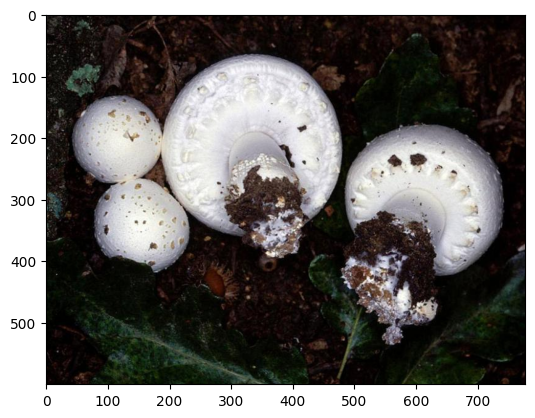

In [4]:
plt.imshow(image)
print(image.shape)

In [4]:
image.shape

(600, 778, 3)

Everything works fine so now let's load all the images and their classes :

In [6]:
_X = []
_y = []

idx = 0
for genus in os.listdir("../raw_data/Mushrooms"):
    for image in os.listdir(f"../raw_data/Mushrooms/{genus}"):
        temp_img = plt.imread( os.path.join("../raw_data/Mushrooms", genus, image))
        if len(temp_img.shape) < 3 : # necessary because there is an image that has no RGB dimension (wtf ??)
                continue
        trans_img = cv2.resize(temp_img, (400, 400), interpolation = cv2.INTER_AREA) # normlizing the pixels of images
        _X.append(trans_img)
        _y.append(genus)
        idx += 1

X = np.concatenate(_X , axis = 0).reshape((idx, 400,400,3)) # putting an image as one item in the tensor
y = np.array(_y)

*Here the image compression is not done, it's just a resizing, the images are stretch*

Print a random image to check that everything seems fine

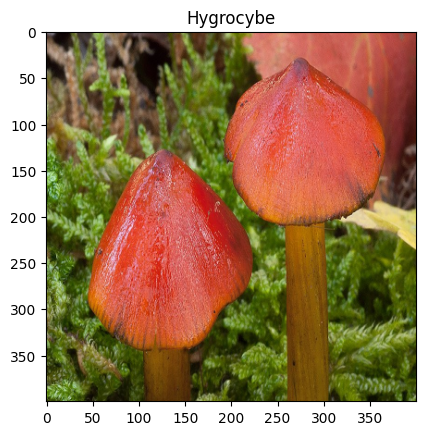

In [9]:
from random import randint

index = randint(0, len(X))

plt.imshow(X[index])
plt.title(y[index]);

Now we can save the preprocessed images in a folder :

If you got an error it's probably because you need to create the directory (`mkdir processed` in terminal) 

**Don't forget to add it to the `.gitignore` file otherwise it will be super long to push...**

In [12]:
# save processed images in a file can be loaded with np.load(file.npy)
np.save("processed/X.npy", X)
np.save("processed/y.npy", y)

By doing this when we reuse this notebook, instead of rerunning the whole images loading, we can directly load the preprocessed ones :

*still take some time though*

## data prep + basic model

In [12]:
X = np.load("processed/X.npy")
y = np.load("processed/y.npy")

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)